# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

**Признаки:**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с- .)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
-  Price — цена (евро)

## Изучение входных данных

### Загрузка данных

In [1]:
# для анализа и работы с данными
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# алгоритмы машинного обучения
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# метрики для алгоритмов ML
from sklearn.metrics import mean_squared_error

# счетчик времени
import time

# константа для алгоритмов ML
RANDOM_STATE = 87

In [2]:
# загрузка датафрейма (try - локально, except - по ссылке)
try:
    df = pd.read_csv('D:/jupyter notebook EDU/data/autos.csv')
   
except:
    df = pd.read_csv('https://_______________autos.csv')
    # УБРАТЬ ПРОБЕЛЫ В ССЫЛКЕ ПЕРЕД ОТПРАВКОЙ!!!

### Функции, используемые в работе

In [3]:
def df_info(df):
    '''
    функиия для вывода основных показателей датафрейма
    
    '''
    print("-"*100)
    print('Общая информамия о датафрейме:')
    print("-"*100)
    print(df.info())
    
    print("-"*100)
    print('Первые 5 строк таблицы')
    print("-"*100)
    display(df.head(5))
    
    print("-"*100)
    print('Количество пропусков')
    print("-"*100)
    print(df.isnull().sum().sort_values(ascending=False))
    
    print("-"*100)
    print('Статистические данные датафрейма')
    print("-"*100)
    display(np.round(df.describe(), 2).T)
    
    print("-"*100)
    print('Количество дубликатов:')
    print("-"*100)
    display(df.duplicated().sum())
    
    print("-"*100)
    print('Визуализация пропущенных данных по строкам датафрейма')
    print("-"*100)
    sns.heatmap(df.isna().transpose(), cmap="coolwarm", cbar_kws={'label': 'Пропуски в данных'})
    plt.show()
    
    print("-"*100)
    print('Корреляция признаков датафрейма')
    print("-"*100)
    sns.heatmap(df.corr(), annot=True, linewidth=.5, cmap='coolwarm')

In [4]:
def price_plot(feature, title):
    '''
    функция для отрисовки графиков зависимости целевого признака от аргумента
    
    '''
    mean_price = df[[feature, 'price']].groupby(feature, as_index=False).mean().astype('int')
    plt.figure(figsize=(10, 3))
    plt.grid(axis = 'both')
    sns.lineplot(x=feature, y='price', data=mean_price)
    plt.xlabel(feature, size=10)
    plt.ylabel('Средняя цена, евро', size=10)
    plt.title(title)
    plt.show()

In [5]:
def fit_time(model, X_train, y_train):
    start = time.time()
    '''
    функция для расчета времени обучения модели
    
    '''
    model.fit(X_train, y_train)
    end = time.time()
    time_fit = end - start
    return time_fit, model

In [6]:
def predict_time(model, X_vaild):
    start = time.time()
    '''
    функция для расчета времени на предсказания модели
    
    '''
    predict = model.predict(X_valid)
    end = time.time()
    time_predict = end - start
    return time_predict, predict

In [7]:
def model_metrics(RMSE, fit_time, pred_time, model_name, df):
    '''
    функция добавит в результат по модели: RMSE, время обучения и время предсказания
    
    '''
    df.loc[model_name,'RMSE'] = RMSE
    df.loc[model_name,'fit_time'] = fit_time
    df.loc[model_name,'predict_time'] = pred_time
    df.loc[model_name,'sum_time'] = pred_time + fit_time
    df.loc[model_name,'Model'] = model_name
    return df

In [8]:
def scale (X_train, X_valid, X_test):
    '''
    функция стандартизации (масштабирования) признаков датафрейма
    
    '''
    scaler = StandardScaler()
    scaler.fit(X_train[X_num])
    X_train[X_num] = scaler.transform(X_train[X_num])
    X_valid[X_num] = scaler.transform(X_valid[X_num])
    X_test[X_num] = scaler.transform(X_test[X_num])

### Общая информация о датафрейме

----------------------------------------------------------------------------------------------------
Общая информамия о датафрейме:
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 n

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


----------------------------------------------------------------------------------------------------
Количество пропусков
----------------------------------------------------------------------------------------------------
Repaired             71154
VehicleType          37490
FuelType             32895
Gearbox              19833
Model                19705
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64
----------------------------------------------------------------------------------------------------
Статистические данные датафрейма
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.66,4514.16,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.23,90.23,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.09,189.85,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.17,37905.34,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.71,3.73,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.69,25783.10,1067.0,30165.0,49413.0,71083.0,99998.0


----------------------------------------------------------------------------------------------------
Количество дубликатов:
----------------------------------------------------------------------------------------------------


4

----------------------------------------------------------------------------------------------------
Визуализация пропущенных данных по строкам датафрейма
----------------------------------------------------------------------------------------------------


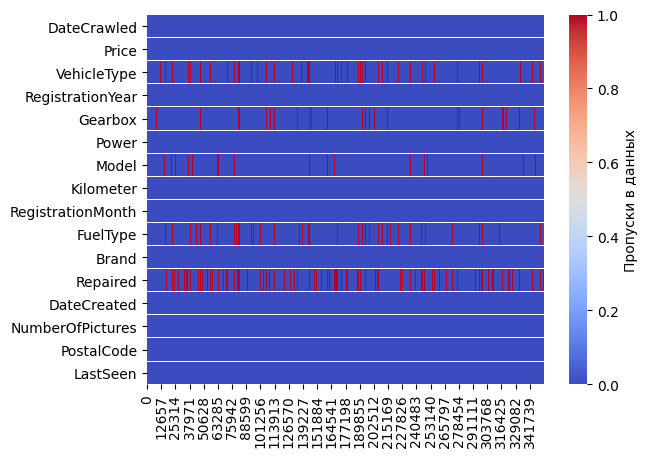

----------------------------------------------------------------------------------------------------
Корреляция признаков датафрейма
----------------------------------------------------------------------------------------------------


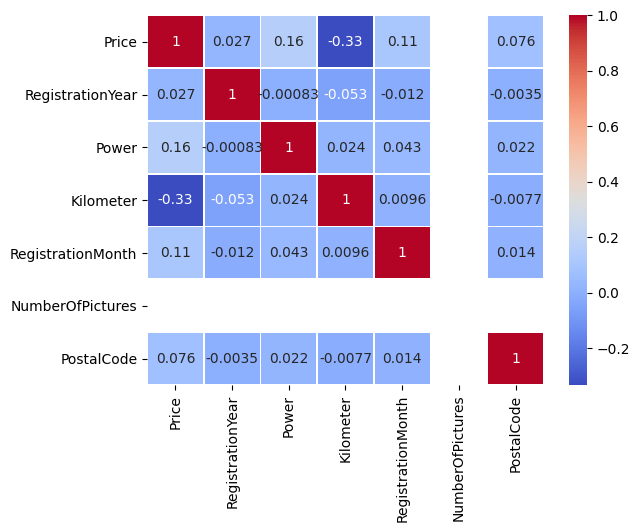

In [9]:
df_info(df)

<function matplotlib.pyplot.show(close=None, block=None)>

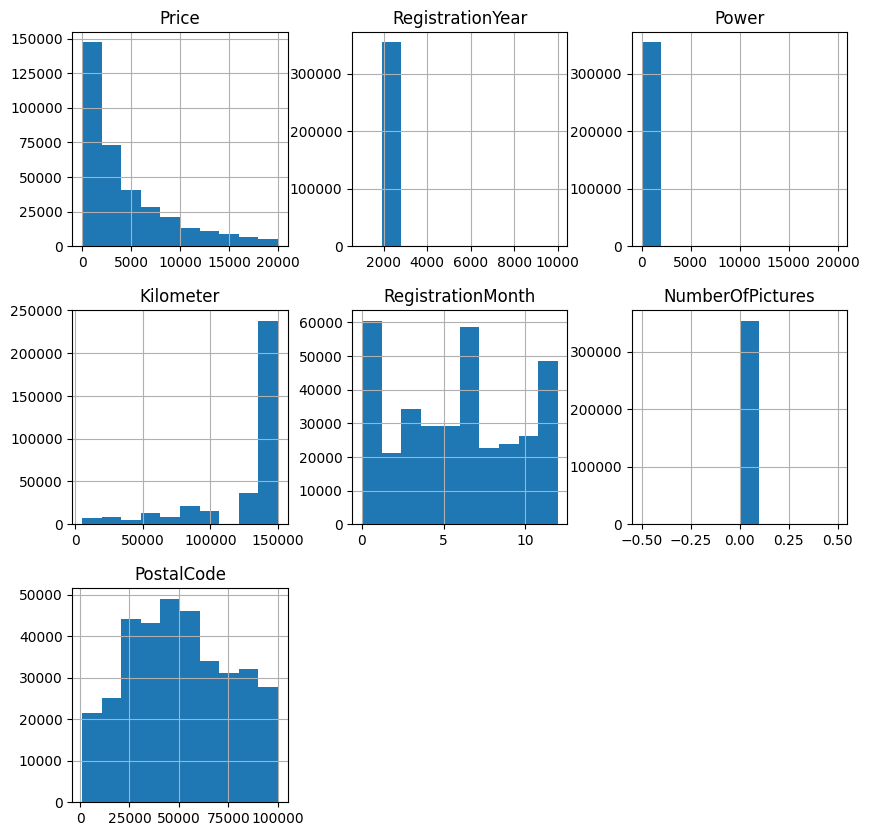

In [10]:
# откроем датафрейм, посмотрим на содержимое
df.hist(figsize=(10, 10))
plt.show

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.2.2:**
    
На основе выведенной общей информации делаем вывод:
1. Всего строк в датафрейме 354 369, что достаточно много для обучения ML, даже если провести "большую чистку"
2. Есть много пропусков в колонках Repaired (71154), VehicleType (37490), FuelType (32895), Gearbox (19833), 
Model (19705). Много. По возможности нужно заполнить
3. Статистические данные датафрейма указывают на выбросы в данных:
- **Price** - есть нулевые значения, их нужно удалить 
- **RegistrationYear** - попадаются годы регистрации как 1000 год, так и 9999 год, такие выбросы нужно удалять,
- **Power** - есть как нулевые, так 20 000 л/с - такие выбросы нужно удалить
- **Kilometer** - минимальный пробег в 5000 км, максимальный в 150 000 - это нормально, бывает и больше разброс. Оставляем, чистить не надо
- **RegistrationMonth** - месяц регистрации минимум 0, максимум 12. Все нормально
- **NumberOfPictures** - все по нулям. Нужно удалить столбец
- **PostalCode** - индекс городов явно не для России ( у нас они имеют шестизначные значение, например, индекс в Самаре 443000), а у нашего датафрейма от 1067 до 99 998. Поиск в интернете подсказал, что это Германия
4. Визуализация пропущенных данных по строкам датафрейма отображает места пропусков в данных. Разброс можно считать равномерный. Нужно чистить, или заполнять в колонках Repaired, VehicleType, FuelType, Gearbox
5. Наибольшая обратная корреляция есть у двух признаков: Kilometer и Price. В признаке с количеством фотографий нет данных для определения корреляции
6. По диаграмме распределения подтверждаются описанные выше выводы на предмет выбросов и аномалий в значениях датафрейма

### Анализ признаков

**ML** сильно зависит от данных. Это самый критически важный аспект, благодаря которому и возможно обучение алгоритма. Для того, чтобы подготовить данные к машинному, нужно их проанализировать.

#### Признаки на удаление

Вначале посмотрим на признаки и оценим какие из них будут мешать машинному обучению для целевого признака **Price** - цена автомобиля. В целевом признаке есть выбросы, которые нужно почистить.

- **DateCrawled** — дата скачивания анкеты из базы.
<br> Такие данные не помогут в определении цены автомобиля. Признак нужно **удалить**

- **VehicleType** — тип автомобильного кузова
<br> Тип кузова влияет на стоимость авто. В целом, чем меньше автомобиль, тем он дешевле. Важный признак, оставляем

- **RegistrationYear** — год регистрации автомобиля
<br> Чем старше автомобиль, тем ниже цена. Признак важный, оставляем

- **Gearbox** — тип коробки передач
<br>  Наличие автоматической коробки передач повышает стоимость автомобиля. Важный признак, оставляем

- **Power** — мощность (л. с- .)
<br> Чем больше мощность, тем выше цена автомобиля. Признак важный, оставляем

- **Model** — модель автомобиля
<br> Марка и модель влияют на стоимость автомобиля. Есть бюджетные модели, а есть премиум. Признак важный, оставляем

- **Kilometer** — пробег (км)
<br>  Чем больше пробег, тем выше стоимость автомобиля. Важный признак, оставляем

- **RegistrationMonth** — месяц регистрации автомобиля
<br>  В конце года автосалоны делают скидки на авто, эти и пользуются покупатели. Важный признак, оставляем

- **FuelType** — тип топлива
<br>  Тип топлива влияет на стоимость эксплуатации автомобиля, а также условий его использования (электромобили далеко не везде можно использовать), поэтому этот признак будет влиять на стоимость автомобиля

- **Brand** — марка автомобиля
<br> Марка и модель влияют на стоимость автомобиля. Есть бюджетные модели, а есть премиум. Признак важный, оставляем

- **Repaired** — была машина в ремонте или нет
<br> Автомобили после ремонта/ДТП менее привлекательные для будущих покупателей. Признак важный, оставляем

- **DateCreated** — дата создания анкеты
<br> Такие данные не помогут в определении цены автомобиля. Признак нужно **удалить**

- **NumberOfPictures** — количество фотографий автомобиля
<br> Наличие и качество фотографий - залог успешной продажи. Чем больше фотографий, тем лучше. Признак важный, но по матрице корреляции видно, что признак пустой. Надо проверить

- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
<br> Стоимость автомобиля зависит от региона его продажи. Признак важный, оставляем

- **LastSeen** — дата последней активности пользователя
<br> Такие данные не помогут в определении цены автомобиля. Признак нужно **удалить**

#### Признак NumberOfPictures - количество фотографий автомобиля

Наличие и качество фотографий - залог успешной продажи. Чем больше фотографий, тем лучше. Посмотрим уникальные значения в колонке

In [11]:
print('Количество уникальных значений в колонке NumberOfPictures:', len(df['NumberOfPictures'].unique()))

Количество уникальных значений в колонке NumberOfPictures: 1


<div style='border:solid green 3px; padding: 20px'>
    
**ВАЖНОЕ ЗАМЕЧАНИЕ**
    
В колонке NumberOfPictures все нули, т.е., колонка либо некорректно заполнена, либо на сайте нет возможности загрузить фото, либо эта функция не работает. Нужно связаться с разработчиками, выяснить причину отсутствия данных. А в данном случае этот признак бесполезен, его нужно удалить

#### Диаграммы распределения признаков

Напишем цикл, который проверяет тип данных каждого столбца и строит boxplot только для числовых столбцов. Таким образом, мы избегаем ошибки "Horizontal orientation requires numeric x variable" и одним циклом построим диаграммы размаха для всех признаков

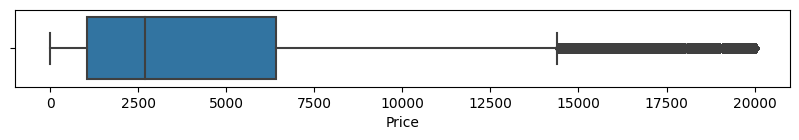

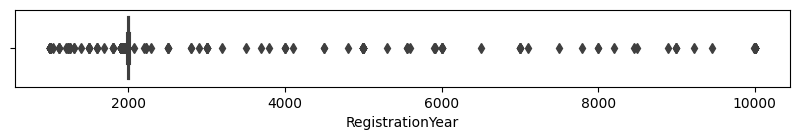

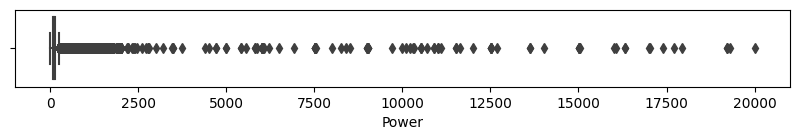

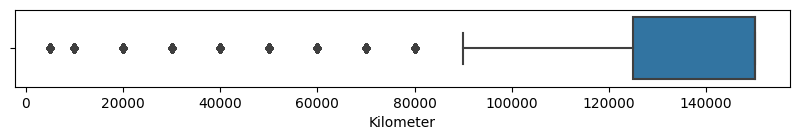

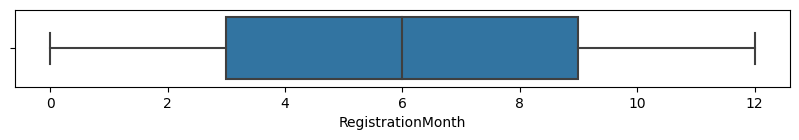

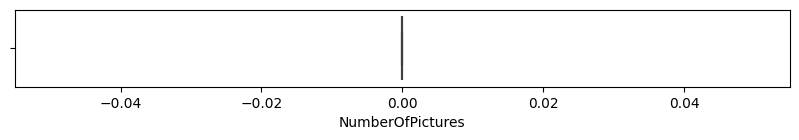

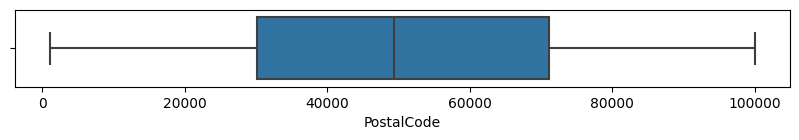

In [12]:
# цикл для построения диаграмм размаха для всех числовых признаков датафрейма
for column in df.columns:
    if df[column].dtype == 'float64' or df[column].dtype == 'int64':
        plt.figure(figsize=(10, 1))
        sns.boxplot(x=df[column])
        plt.show()

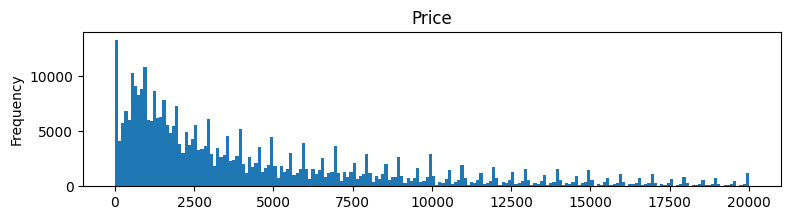

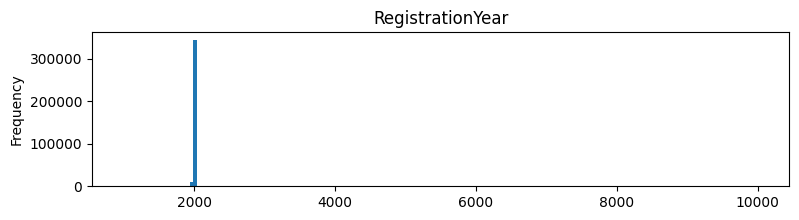

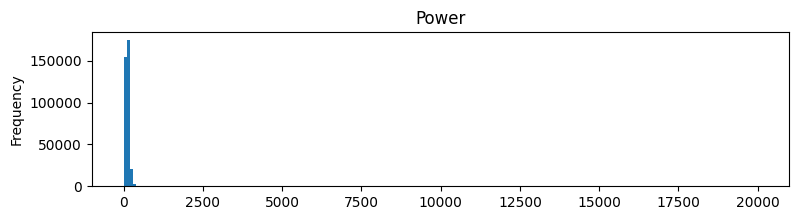

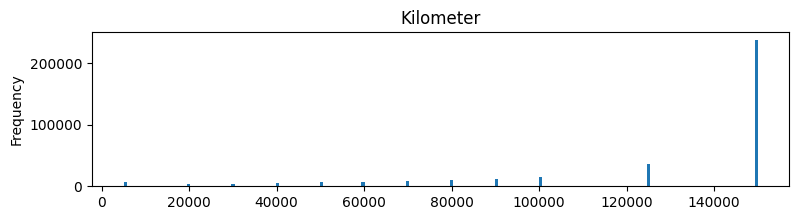

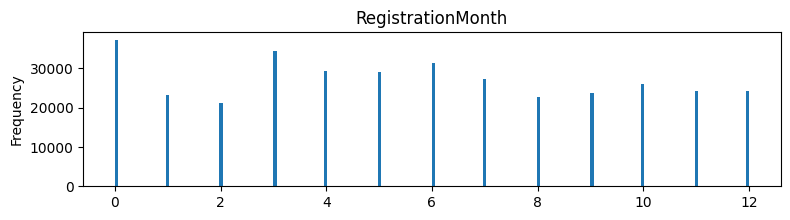

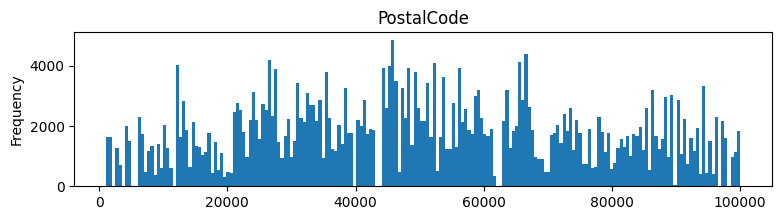

In [13]:
# список для построения и анализа диаграмм
list_columns = ['Price',
                'RegistrationYear',
                'Power',
                'Kilometer',
                'RegistrationMonth',
                'PostalCode']

# цикл для построения диаграмм размаха для всех числовых признаков датафрейма
for column in list_columns:
    df[column].sort_values().plot(y = column, kind = 'hist', bins = 200, figsize=(9, 2), legend=False)
    plt.title(column)
    plt.show()

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.2.4.3:**

- в признаках (такие как год регистрации автомобиля, мощность) есть выбросы, которые нужно более детально анализировать и принять решение что с ними делать
- признаки с адекватными данными: цена (целевой признак), пробег, мепсяц регистрации автомобиля, регион
- в признаке Количество фотографий отсуствуют значения кроме нуля

#### Признак RegistrationYear - год регистрации авто

Признаки **RegistrationYear и Power** явно имеет некорректно заполненные данные. Проанализируем их

In [14]:
# посмотрим на уникальные значения признака RegistrationYear
df['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Годы регистрации автомобилей после 2019 и до 1970 являются аномалиями, их нужно удалить. Посмотрим как будет выглядеть диаграмма признака после удаления (с помощью xlim в диапазоне от 1970 до 2019г).

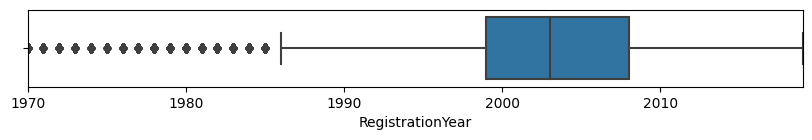

In [15]:
# построение диаграммы размаха
plt.figure(figsize=(10, 1))
sns.boxplot(x=df['RegistrationYear'])
plt.xlim(1970, 2019)
plt.show()

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.2.4.5:**
 
годы регистрации автомобилей после 2019 и до 1970 являются аномалиями, их нужно удалить следующим шагом


#### Признак Power - мощность (л. с- .)

На основе данных п.2.4.4 видны выбросы в значениях мощности автомобилей. Есть значения вплоть до 20 000 л/с, а также меньше 10. Посчитаем сколько у нас значений до 10 л/с и больше 1000 л/с

In [16]:
# больше 1000 л/с
count = len(df[df['Power'] >= 1000])
print('Количество строк больше 1000 л/с:', count)

# меньше 10 л/с
count = count = len(df[df['Power'] <= 10])
print('Количество строк меньше 10 л/с:', count)

# суммарно
count = len(df[(df['Power'] >= 1000) | (df['Power'] <= 10)])
print('Количество строк до 10 л/с и больше 1000 л/с суммарно:', count)

Количество строк больше 1000 л/с: 310
Количество строк меньше 10 л/с: 40460
Количество строк до 10 л/с и больше 1000 л/с суммарно: 40770


Будем считать эти данные выбросом, их нужно удалить

Результат фильтрации на диаграмме

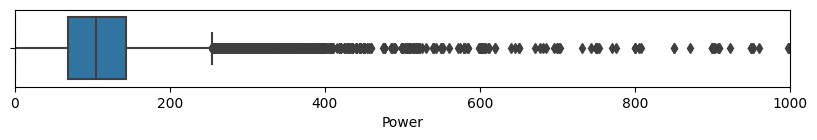

In [17]:
# построение диаграммы размаха
plt.figure(figsize=(10, 1))
sns.boxplot(x=df['Power'])
plt.xlim(0, 1000)
plt.show()

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.2.4.5:**
    
Признак с мощностью автомобилей есть явные выбросы как больше 1000 л/с (врядли это суперкары), так и менее 10 л/с (что за тачка на колесах?). Следующим шагом следует удалить выбросы в диапазоне от 10 до 1000 л/с

#### Признак Kilometer — пробег (км)

Проведем анализ пробега автомобилей, выведем статистический анализ признака:

In [18]:
# статистические данные признака Kilometer
df['Kilometer'].describe()

count    354369.000000
mean     128211.172535
std       37905.341530
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

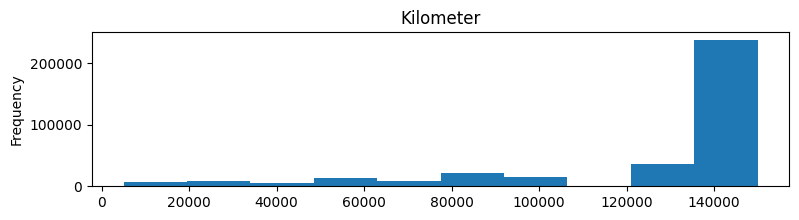

In [19]:
# построение диаграммы признака Kilometer
df['Kilometer'].sort_values().plot(kind = 'hist', bins = 10, figsize=(9, 2), legend=False)
plt.title('Kilometer')
plt.show()

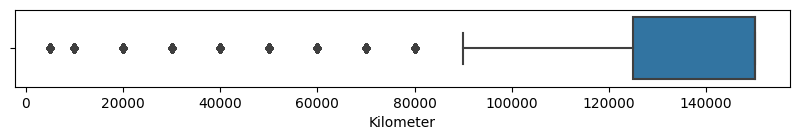

In [20]:
# построение диаграммы размаха
plt.figure(figsize=(10, 1))
sns.boxplot(x=df['Kilometer'])
plt.show()

In [21]:
# посмотрим на уникальные значения признака Kilometer
df['Kilometer'].sort_values().unique()

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000], dtype=int64)

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.2.4.5:**
    
С пробегом в целом всё в порядке. Следующим шагом следует более детально рассмотреть зависимость стоимости автомобилей от пробега

#### Проверка на неявные дубликаты в признаке Model

Посмотрим есть ли похожие названия одной и той же марки автомобилей

In [22]:
# посмотрим на уникальные значения признака Model
df['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.2.3.6:**
    
- выбросов в признаке нет
- в объявлениях указывают ровное значение пробега авто, всего уникальных значений пробега - 13
- есть некоторые пробелы в значениях пробега диапазона 100-150тыс.км, а именно шаг идет 100, 125 и 150, интересное наблюдение. При большом пробеге величина пробега становится менее значимым, чем при малом пробеге
- автомобилей с пробегом более 150тыс.км нет, вероятно, что есть ограничение системы по публикациям объявлений. При этом бОльшая часть автомобилей, их медиана составляет тот самый максимум - 150тыс.км 

## Подготовка данных

### Удаление дубликатов

Полных дубликатов всего 5 строк, удалим их, чтобы не мешали ML

In [23]:
# Удаляем
df = df.drop_duplicates()

# Проверяем
df.duplicated().sum()

0

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.3.1:**
    
 Дубликато всего пять строк - это радует. Смело удаляем их

### Удаление ненужных признаков

In [24]:
# список признаков датафрейма
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Признаки, которые подлежат удалению в соответствии с пунктом 2.3.1:
- DateCrawled,
- DateCreated,
- LastSeen,
- NumberOfPictures

In [25]:
# удаляем признаки
df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures'], axis=1, inplace=True)

Проверим итоговый датафрейм после удаления ненужных признаков

In [26]:
# список признаков датафрейма после удаления
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired',
       'PostalCode'],
      dtype='object')

In [27]:
df.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437


<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.3.2:**
    
Признаки, которые не могут оказать влияние на результаты машинного обучения следует удалить. К ним относятся:
    
**DateCrawled, DateCreated, LastSeen, NumberOfPictures**

### Удаление аномалий в признаках

Годы регистрации автомобилей после 2019 и до 1970 являются аномалиями, удалим их

In [28]:
# удаление выбросов
df = df[(df['RegistrationYear'] >= 1970) & (df['RegistrationYear'] <= 2019)]

# провервка удаления - вывод отсортированных уникальных значений
df['RegistrationYear'].sort_values().unique()

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019], dtype=int64)

На основе данных п.2.2 и 2.3.5 видны выбросы в значениях мощности автомобилей. Есть значения вплоть до 20 000 л/с, а также меньше 10. Значения до 10 л/с и больше 500 л/с будем считать выбросом, удалим их

In [29]:
# удаление выбросов
df = df[(df['Power'] >= 10) & (df['Power'] <= 1000)]

# статистические данные признака
df['Power'].describe()

count    312835.000000
mean        120.414733
std          54.666617
min          10.000000
25%          75.000000
50%         110.000000
75%         150.000000
max        1000.000000
Name: Power, dtype: float64

Удалим выбросы в целевом признаке

In [30]:
df = df.drop(df.query('Price < 100').index)

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.3.3:**
    
удалены строки с аномалиями в признаках: 
- год регистрации автомобилей старше 1970г и младше 2019г;
- мощность автомобилей более 1000 л/с и менее 10л/с;
- удалены выбросы в целевом признаке с ценой автомобилей менее 100 евро

### Обработка пропусков

На основе данных п.2.2, в датафрейме есть пропуски в следующих признаках:
- Repaired             71154
- VehicleType          37490
- FuelType             32895
- Gearbox              19833
- Model                19705

Обработаем пропуски так:
- **Repaired** заменим пропуски на значение "0", вероятнее всего если пользователи эту строку не заполняли, значит, машина не была в ремонте. При этом сделаем замену значений "yes" на "1", а значение "no" на "0";

- **VehicleType** в этом признаке неизвестен тип кузова. Такие пропуски лучше удалить
- **FuelType** наиболее популярный тип топлива на сегодня - бензин, вероятнее всего пользователи с бензиновым двигателем не стали заполнять эту строку, предполагая, что бензин - это топливо "по умолчанию". Заменим пропуски на значение "1". Также в этом признаке нужно найти все уникальные значения и присвоить каждому типу толпива цифровое значение. Таким образом модель ML сможет обучаться на таких данных

- **Gearbox** похожая ситуация с коробкой передач, по всей видимости пропуски соответствуют механической коробке передач. Заменим пропуски на "0", значение "manual" заменим тоже на "0", а "auto" заменим на "1"

- **Model** пропуски в этом признаке ничем не заменить. Удалим их

#### Признак Repaired - была машина в ремонте или нет

In [31]:
# заменим пропуски (NaN) на '0':
df['Repaired'].fillna(0, inplace=True)

In [32]:
# в признаке gearbox заменим значение "no" на 0, "yes" - на 1:
df.loc[(df.Repaired == 'no'), 'Repaired'] = 0   
df.loc[(df.Repaired == 'yes'), 'Repaired'] = 1

In [33]:
# проверим результат замены
df.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,1,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,0,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,1,33775


In [34]:
# проверим количество пропусков
df['Repaired'].isnull().sum()

0

#### Признак FuelType - тип топлива

FuelType наиболее популярный тип топлива на сегодня - бензин, вероятнее всего пользователи с бензиновым двигателем не стали заполнять эту строку, предполагая, что бензин - это топливо "по умолчанию". Заменим пропуски на значение "1". Также в этом признаке нужно найти все уникальные значения и присвоить каждому типу толпива цифровое значение. Таким образом модель ML сможет обучаться на таких данных

In [35]:
# заменим пропуски (NaN) на '1':
df['FuelType'].fillna(1, inplace=True)

Посмотрим на уникальные значения данного признака

In [36]:
# уникальные значения признака
df['FuelType'].unique()

array(['gasoline', 'petrol', 1, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Сделаем замену значений типа топлива на цифровые значения:
- 'petrol' на 1
- 'gasoline' на 2
- 'lpg' на 3
- 'hybrid' на 4
- 'cng' на 5
- 'electric' на 6
- 'other' на 0

In [37]:
# замена категориальных признаков на числовые
df['FuelType'].replace({'petrol': 1,
                        'gasoline': 2,
                        'lpg': 3,
                        'hybrid': 4,
                        'cng': 5,
                        'electric': 6,
                        'other': 0}, inplace=True)

In [38]:
# проверим результат замены
df.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
1,18300,coupe,2011,manual,190,NaN,125000,5,2,audi,1,66954
2,9800,suv,2004,auto,163,grand,125000,8,2,jeep,0,90480
3,1500,small,2001,manual,75,golf,150000,6,1,volkswagen,0,91074
4,3600,small,2008,manual,69,fabia,90000,7,2,skoda,0,60437
5,650,sedan,1995,manual,102,3er,150000,10,1,bmw,1,33775


In [39]:
# проверим количество пропусков
df['FuelType'].isnull().sum()

0

#### Признак Gearbox -  тип коробки передач

In [40]:
# заменим пропуски (NaN) на '0':
df['Gearbox'].fillna(0, inplace=True)

In [41]:
# в признаке gearbox заменим значение manual на 0, auto - на 1:
df.loc[(df.Gearbox == 'manual'), 'Gearbox'] = 0   
df.loc[(df.Gearbox == 'auto'), 'Gearbox'] = 1

In [42]:
# проверим результат замены
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
1,18300,coupe,2011,0,190,NaN,125000,5,2,audi,1,66954
2,9800,suv,2004,1,163,grand,125000,8,2,jeep,0,90480
3,1500,small,2001,0,75,golf,150000,6,1,volkswagen,0,91074
4,3600,small,2008,0,69,fabia,90000,7,2,skoda,0,60437
5,650,sedan,1995,0,102,3er,150000,10,1,bmw,1,33775


In [43]:
# проверим количество пропусков
df['Gearbox'].isnull().sum()

0

#### Удалим остатки пропусков

Посмотрим сколько пропусков в каких признаках осталоись

In [44]:
# всего пропусков в датафрейме:
df.isnull().sum().sort_values(ascending=False)

VehicleType          21023
Model                11970
Price                    0
RegistrationYear         0
Gearbox                  0
Power                    0
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired                 0
PostalCode               0
dtype: int64

In [45]:
# удаление оставшихся пропусков
df.dropna(inplace=True)

In [46]:
# всего строк осталось:
df.shape

(274552, 12)

<div style='border:solid green 3px; padding: 20px'>
    
**ВАЖНОЕ ЗАМЕЧАНИЕ**
    
Вначале всего строк было 354 369, после очистки аномалий, замены где это было наиболее "безопасно" и удаления пропусков стало 274 552. Таким образом, датафрейм уменьшился на 22%. Это много, но даже после удаления такого объема данных вполне достаточно для хорошего обучения моделей, при этом такие данные будут являться более качественными. Пропуски можно было бы заполнить медианой, модой, или значениями unknow, но в таком случае данные будут искажены и качество модели для предсказаний цены будет хуже.

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.3.4:**

обработка пропусков в признаках:
- **Repaired** заменили пропуски на значение "0", вероятнее всего если пользователи эту строку не заполняли, значит, машина не была в ремонте. При этом сделаем замену значений "yes" на "1", а значение "no" на "0";

- **VehicleType** в этом признаке неизвестен тип кузова. Такие пропуски были удалены
- **FuelType** наиболее популярный тип топлива на сегодня - бензин, вероятнее всего пользователи с бензиновым двигателем не стали заполнять эту строку, предполагая, что бензин - это топливо "по умолчанию". Заменили пропуски на значение "1". Также в этом признаке нужно найти все уникальные значения и присвоить каждому типу толпива цифровое значение. Таким образом модель ML сможет обучаться на таких данных
- **Gearbox** похожая ситуация с коробкой передач, по всей видимости пропуски соответствуют механической коробке передач. Заменили пропуски на "0", значение "manual" заменили тоже на "0", а "auto" заменили на "1"
- **Model** пропуски в этом признаке ничем не заменить. Их удалили
- остальные пропуски в признаках VehicleType (21 023 строк) и Model (11 970 строк) были удалены

### Приведение названий признаков к нижнему регистру

In [47]:
# вспомним признаки
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired',
       'PostalCode'],
      dtype='object')

В датафрейме в названиях признаков есть разный регистр. Приведем их нижнему регистру с разделением нижним подчеркиванием, где начинается прописная буква

In [48]:
# цикл для приведения к нижнему регистру с разделением нижним подчеркиванием после прописной буквы в названиях признаков
for i, s in enumerate(df.columns):
    s = ''.join(['_' + c.lower() if c.isupper() else c for c in s]).lstrip('_')
    df = df.rename(columns={df.columns[i]: s})
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'postal_code'],
      dtype='object')

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.3.5:**

названия признаков были заменены в змеином стиле в сответствии с **PEP8**, хотя мне больше нравится как было :)

### Итоговый датафрейм

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274552 entries, 2 to 354368
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               274552 non-null  int64 
 1   vehicle_type        274552 non-null  object
 2   registration_year   274552 non-null  int64 
 3   gearbox             274552 non-null  object
 4   power               274552 non-null  int64 
 5   model               274552 non-null  object
 6   kilometer           274552 non-null  int64 
 7   registration_month  274552 non-null  int64 
 8   fuel_type           274552 non-null  int64 
 9   brand               274552 non-null  object
 10  repaired            274552 non-null  object
 11  postal_code         274552 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 27.2+ MB


In [50]:
# итоговый датафрейм после подготовки
df.head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code
2,9800,suv,2004,1,163,grand,125000,8,2,jeep,0,90480
3,1500,small,2001,0,75,golf,150000,6,1,volkswagen,0,91074
4,3600,small,2008,0,69,fabia,90000,7,2,skoda,0,60437
5,650,sedan,1995,0,102,3er,150000,10,1,bmw,1,33775
6,2200,convertible,2004,0,109,2_reihe,150000,8,1,peugeot,0,67112
8,14500,bus,2014,0,125,c_max,30000,8,1,ford,0,94505
9,999,small,1998,0,101,golf,150000,0,1,volkswagen,0,27472
10,2000,sedan,2004,0,105,3_reihe,150000,12,1,mazda,0,96224
11,2799,wagon,2005,0,140,passat,150000,12,2,volkswagen,1,57290
12,999,wagon,1995,0,115,passat,150000,11,1,volkswagen,0,37269


<function matplotlib.pyplot.show(close=None, block=None)>

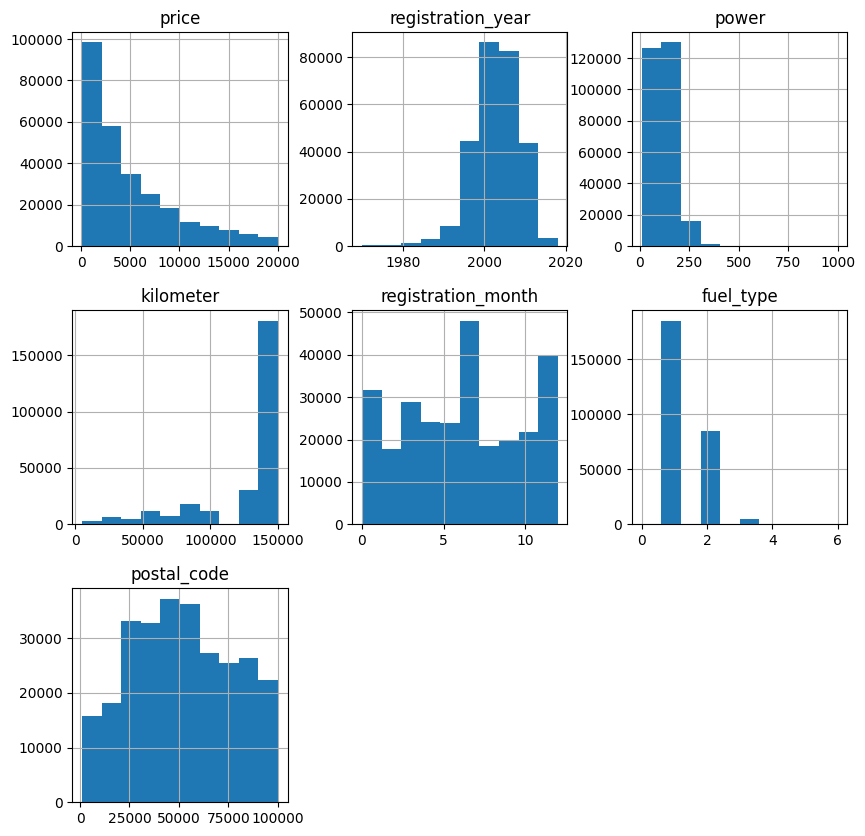

In [51]:
df.hist(figsize=(10, 10))
plt.show

<AxesSubplot:>

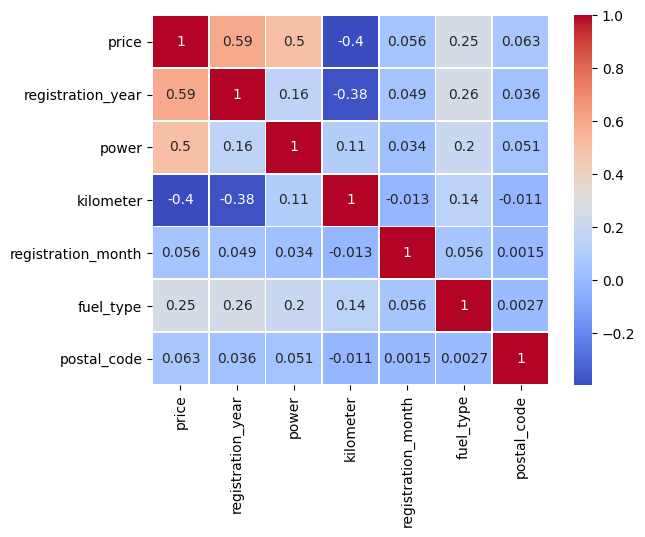

In [52]:
sns.heatmap(df.corr(), annot=True, linewidth=.5, cmap='coolwarm')

In [53]:
display(np.round(df.describe(), 2).T)

,count,mean,std,min,25%,50%,75%,max
price,274552.0,4988.69,4631.63,100.0,1450.0,3350.0,7200.0,20000.0
registration_year,274552.0,2002.79,5.90,1970.0,1999.0,2003.0,2007.0,2018.0
power,274552.0,121.47,54.10,10.0,80.0,114.0,150.0,1000.0
kilometer,274552.0,128147.31,36588.23,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,274552.0,6.09,3.54,0.0,3.0,6.0,9.0,12.0
fuel_type,274552.0,1.35,0.54,0.0,1.0,1.0,2.0,6.0
postal_code,274552.0,51406.33,25751.64,1067.0,31061.0,50679.0,72202.0,99998.0


<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.3.6:**

- датафрейм преобразился: без пропусков, без выбросов
- сразу стала видна корреляция признаков

### Изменение целевого признака  Price от других признаков

Проведем анализ стоимости автомобилей (целевого признака Price) в зависимости от других признаков

In [54]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'postal_code'],
      dtype='object')

Вызовем функцию `def price_plot` с аргументами: **(feature, title)**

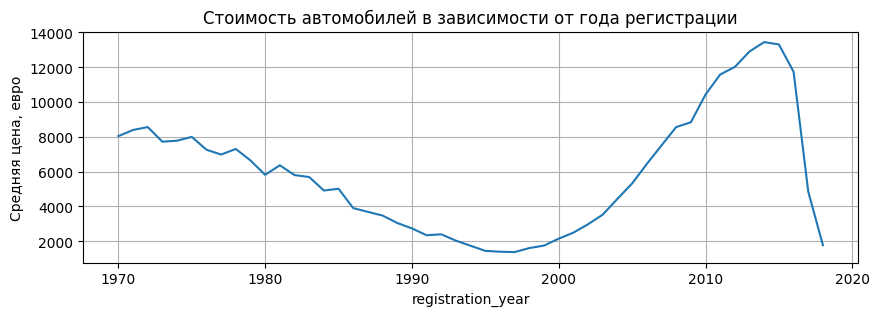

In [55]:
price_plot('registration_year', 'Стоимость автомобилей в зависимости от года регистрации')

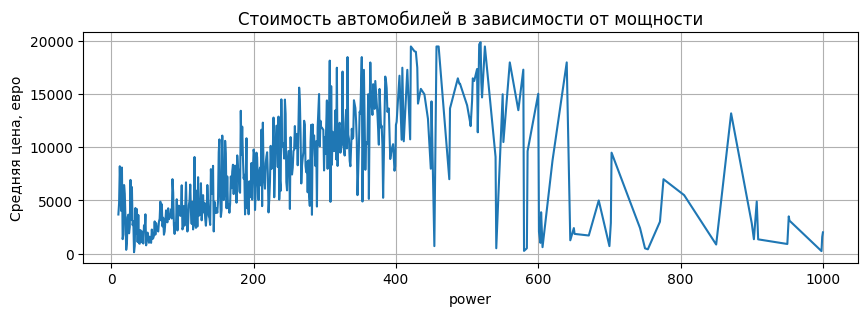

In [56]:
price_plot('power', 'Стоимость автомобилей в зависимости от мощности')

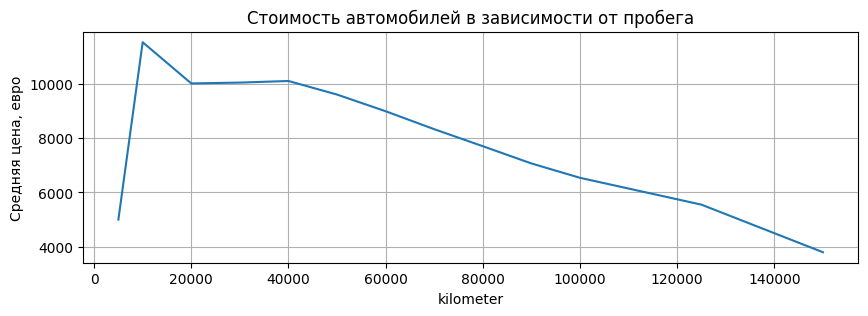

In [57]:
price_plot('kilometer', 'Стоимость автомобилей в зависимости от пробега')

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.3.7:**
    
- стоимость автомобилей зависит от года его регистрации (производства) чем старше автомобиль - тем дешевле, однако, это не относится к раритетным авто (старше 1985г) цена которых наоборот возрастает. - наблюдается пик стоимости автомобилей для 2015г, те, что моложе идут на спад. Вероятно, что дешевые свежие автомобили **всё-таки либо биты, либо окрашены, либо и то и другое**
- чем мощнее автомобиль, тем он дороже
- чем больше пробег - тем он дешевле

## Подготовка данных для обучения моделей

In [58]:
# признаки датафрейма
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'postal_code'],
      dtype='object')

Сбросим индексы, после удаления лишних значений

In [59]:
# Сброс индексов
df = df.reset_index(drop=True)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code
0,9800,suv,2004,1,163,grand,125000,8,2,jeep,0,90480
1,1500,small,2001,0,75,golf,150000,6,1,volkswagen,0,91074
2,3600,small,2008,0,69,fabia,90000,7,2,skoda,0,60437
3,650,sedan,1995,0,102,3er,150000,10,1,bmw,1,33775
4,2200,convertible,2004,0,109,2_reihe,150000,8,1,peugeot,0,67112


In [60]:
# списки категориальных X_cat и числовых признаков X_num датафрейма
X_cat = ['vehicle_type', 'gearbox', 'model', 'fuel_type',
                        'brand', 'repaired', 'postal_code']
X_num = ['registration_year', 'power', 'kilometer', 'registration_month']

### Подготовка категориальных признаков

 Желательно избегать большого числа столбцов из множества категорий. Для моделей на основе дерева решений категориальные признаки можно закодировать с помощью порядкового кодирования, для линейных моделей - OHE-encoding, а в случае LightGBM и Catboost категориальные признаки можно предварительно не обрабатывать, а использовать встроенные методы.

Порядковое кодирование методом OrdinalEncoder

In [61]:
# # выбираем кодировщик - объект OrdinalEncoder
# encoder_oe = OrdinalEncoder()

# # вызываем его метод fit для обучения кодировщика на категориальных признаках
# encoder_oe.fit(df[X_cat])

# # сделаем копию датафрейма
# df_oe = df.copy()

# # категориальные признаки в копии датафрейма df_oe заменяем на закодированные значения,
# # которые были получены с помощью метода transform объекта OrdinalEncoder
# df_oe[X_cat] = pd.DataFrame(encoder_oe.transform(df[X_cat]), columns = df[X_cat].columns)

<div class="alert alert-danger">
    ❌ <b>Комментарий ревьюера</b>
    
Кодировать при помощи OrdinalEncoder на всем сете - не совсем честный подход. Правильнее было бы обучить только на train, а затем использовать для преобразования на всех сетах. Потому что в таком случае мы заранее знаем, что у нас будут только такие значения признаков и никаких других. В каких-то случаях это адекватный подход, а в каких-то новые значения появляются постоянно и нужно, чтобы модель умела с таким работать.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента</b> 

Делая таким образом кодировку категориальных признаков я исходил из той логики, что кодирование категориальных признаков методом OrdinalEncoder должно происходить на этапе предобработки данных, до разделения датафрейма на выборки train, valid и test. Ведь это необходимо для того, чтобы значения категориальных признаков были преобразованы в числовые значения единообразным способом для всех выборок. Если кодирование будет производиться после разделения на выборки, то это может привести к тому, что значения категориальных признаков будут преобразованы по-разному для каждой выборки, что может исказить результаты моделирования. Есть же модели машинного обучения, которые могут работать с категориальными признаками без кодирования, например, деревья решений и случайные леса, но, большинство моделей требуют числовых значений (а у меня их пять разных), поэтому было применено кодирование перед разбивкой, чтобы подготовить универсальный датафрейм, с которым смогут работать все модели.
    
Исходя из твоего замечания я так понял, что кодировку OrdinalEncoder нужно применять только на тренировочном наборе данных после разделения его на обучающую и валидационную выборки.
    
Сделал как я понял из твоего комментария:
    
1) извлек целевой признак
2) разбил на выборки трейн, валид, тест
3) сделал категоризацию методом OrdinalEncoder фит на трейн, трансформ на валид и тест на выборках X_train, X_valid, X_test
4) стандартизировал методом StandardScaler выборки X_train, X_valid, X_test
    

<div class="alert alert-success">
    ✔️ <b>Комментарий ревьюера v2</b>

Если мы обучаем кодировщик только на train и потом применяем к остальным сетам, то кодировка будет одной и той же. Вообще это делается для того, чтобы быть устойчивым к таким случаям, когда в продакшене появляются новые категории и модель справляется с этим. Поэтому мы заранее к такому готовимся и проверяем, что все не падает по качеству (по лесу посмотрим чуть дальше).
    
Если же мы уверены, что количество категорий фиксировано и мы все их знаем и точно не будет больше, то можно закодировать на всем сете.
    
Помимо такого кодирования, кстати, можно иногда пользоваться другими способами, например, TargetEncoder ([документация тут](https://contrib.scikit-learn.org/category_encoders/targetencoder.html))
</div>

### Извлечение целевого признака

In [62]:
# создадим два датафрейма: Х - без целевого признака, у - только с одним целевым признаком Price
# для датафреймов с кодированием признаков методом OrdinalEncoder (OE)
X = df.drop('price',axis=1)
y = df['price']

### Разбивка на выборки train, test

In [63]:
# разделяем данные на обучающую и валидационную выборки в соотношении 60/40 (обучающая/валидационная)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.40, random_state = RANDOM_STATE)

# разделяем поровну (по 50% от 40% оставшихся данных, или по 20% от исходных) валидационную и тестовую выборку
X_valid, X_test, y_valid, y_test = train_test_split(
    X, y, test_size=0.50, random_state = RANDOM_STATE)

print("Размер обучающей выборки:", X_train.shape)
print("Размер обучающей выборки:", X_valid.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (164731, 11)
Размер обучающей выборки: (137276, 11)
Размер тестовой выборки: (137276, 11)


### Подготовка категориальных признаков

In [64]:
encoder = OrdinalEncoder(handle_unknown='ignore')
encoder.fit(pd.concat([X_train[X_cat], X_valid[X_cat], X_test[X_cat]], axis=0))

X_train[X_cat] = encoder.transform(X_train[X_cat])
X_valid[X_cat] = encoder.transform(X_valid[X_cat])
X_test[X_cat] = encoder.transform(X_test[X_cat])

### Стандартизация (масштабирование) данных методом StandardScaler

In [65]:
# вызываем функцию для стандартизации признаков
scale (X_train, X_valid, X_test)

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы п.4:**
    
выполнена подготовка данных для обучения моделей ML:
- сброшены индексы после предобработки данных
- созданы списки с категориальными и числовыми признаками датафрейма
- выполнено преобразование категориальных признаков в числовые
- извлечен целевой признак, выполнена разбивка данных на обучающие и тестовые выборки
- проведена стандартизация (масштабирование) данных

## Обучение моделей

In [66]:
# для записи результатов работы моделей
model_result = pd.DataFrame(columns=['RMSE', 'fit_time', 'predict_time', 'sum_time', 'Model'])

### Линейная регрессия LinearRegression

Обучим модель линейной регрессии на закодированных значениях признаков и оценим ее производительность на тестовых данных. 

Сначала создадим объект класса `LinearRegression()` и передадим в функцию `learn_time` вместе с обучающими данными `X_train_oe` и `y_train_oe`. Функция `learn_time` возвращает время обучения модели и саму модель.

Затем модель используется для предсказания значений на тестовых данных с помощью функции `predict_time`, которая возвращает время предсказания и предсказанные значения.

Далее вычисляется среднеквадратичное отклонение между предсказанными и реальными значениями с помощью функции `mean_squared_error` из библиотеки `numpy`. Результат сохраняется в переменную `LR_RMSE`.

Наконец, результаты оценки модели (RMSE, время обучения и время предсказания) передаются в функцию `model_metrics`, которая добавляет их в словарь `model_result` под названием `Linear regression`.

In [67]:
LR_fit_time, LR_model = fit_time(LinearRegression(), X_train, y_train)
LR_pred_time, LR_predict = predict_time(LR_model, X_valid)
LR_RMSE = np.sqrt(mean_squared_error(y_valid, LR_predict))
model_metrics(LR_RMSE, LR_fit_time, LR_pred_time, 'LinearRegression', model_result)

,RMSE,fit_time,predict_time,sum_time,Model
LinearRegression,2852.605558,0.041009,0.010009,0.051018,LinearRegression


### Ridge - регрессия

Работа кода описанного ниже для `Ridge` - регрессии аналагично работе кода описанного выше для Линейной регрессии `LinearRegression`

In [68]:
Ridge_fit_time, Ridge = fit_time(Ridge(alpha=1, random_state=RANDOM_STATE), X_train, y_train)
Ridge_pred_time, Ridge_predict = predict_time(Ridge, X_valid)
Ridge_RMSE = np.sqrt(mean_squared_error(y_valid, Ridge_predict))
model_metrics(Ridge_RMSE, Ridge_fit_time, Ridge_pred_time,'Ridge', model_result)

,RMSE,fit_time,predict_time,sum_time,Model
LinearRegression,2852.605558,0.041009,0.010009,0.051018,LinearRegression
Ridge,2852.60552,0.019005,0.004009,0.023014,Ridge


### RandomForestRegressor

In [69]:
RFR_fit_time, RFR = fit_time(RandomForestRegressor(n_estimators=10, random_state=RANDOM_STATE), X_train, y_train)
RFR_pred_time, RFR_predict = predict_time(RFR, X_valid)
RFR_RMSE = np.sqrt(mean_squared_error(y_valid, RFR_predict))
model_metrics(RFR_RMSE, RFR_fit_time, RFR_pred_time, 'RandomForestRegressor', model_result)

,RMSE,fit_time,predict_time,sum_time,Model
LinearRegression,2852.605558,0.041009,0.010009,0.051018,LinearRegression
Ridge,2852.60552,0.019005,0.004009,0.023014,Ridge
RandomForestRegressor,674.932309,5.831316,0.414094,6.24541,RandomForestRegressor


<div style='border:solid green 3px; padding: 20px'>
    
**ВАЖНОЕ ЗАМЕЧАНИЕ**
    
Была еще использована модель **RandomForestClassifier**, которая показала гораздо хуже результат как по времени, так и по качеству чем **RandomForestRegressor**, поэтому была оставлена последняя, потому что это задача регрессии, а не классификации

### LGBMRegressor

Работа кода описанного ниже для `LGBMRegressor` - регрессии аналагично работе кода описанного выше для Линейной регрессии `LinearRegression`

In [70]:
lgbm_fit_time, lgbm = fit_time(LGBMRegressor(
    n_estimators=1000, random_state=RANDOM_STATE, learning_rate=0.4, objective='rmse'), X_train, y_train)
lgbm_pred_time, lgbm_predict = predict_time(lgbm, X_valid)
lgbm_RMSE = np.sqrt(mean_squared_error(y_valid, lgbm_predict))
model_metrics(lgbm_RMSE, lgbm_fit_time, lgbm_pred_time, 'LGBMRegressor', model_result)

,RMSE,fit_time,predict_time,sum_time,Model
LinearRegression,2852.605558,0.041009,0.010009,0.051018,LinearRegression
Ridge,2852.60552,0.019005,0.004009,0.023014,Ridge
RandomForestRegressor,674.932309,5.831316,0.414094,6.24541,RandomForestRegressor
LGBMRegressor,1009.458334,2.792967,0.766172,3.559139,LGBMRegressor


### CatBoostRegressor

Работа кода описанного ниже для `CatBoostRegressor` - регрессии аналагично работе кода описанного выше для Линейной регрессии `LinearRegression`

In [71]:
catboost_fit_time, catboost = fit_time(CatBoostRegressor(
    loss_function='RMSE', learning_rate=0.4, verbose=100, n_estimators=1000, random_state=RANDOM_STATE), X_train, y_train)
catboost_pred_time, catboost_predict = predict_time(catboost, X_valid)
catboost_RMSE = np.sqrt(mean_squared_error(y_valid, catboost_predict))
model_metrics(catboost_RMSE, catboost_fit_time, catboost_pred_time, 'CatBoostRegressor', model_result)

0:	learn: 3427.7019892	total: 185ms	remaining: 3m 5s
100:	learn: 1560.7117500	total: 1.45s	remaining: 12.9s
200:	learn: 1476.2764006	total: 2.84s	remaining: 11.3s
300:	learn: 1427.8856143	total: 4.13s	remaining: 9.59s
400:	learn: 1391.5748141	total: 5.39s	remaining: 8.05s
500:	learn: 1363.1172595	total: 6.65s	remaining: 6.62s
600:	learn: 1339.8684899	total: 7.87s	remaining: 5.22s
700:	learn: 1318.0069550	total: 9.16s	remaining: 3.91s
800:	learn: 1298.3634597	total: 10.6s	remaining: 2.62s
900:	learn: 1279.7703427	total: 11.8s	remaining: 1.3s
999:	learn: 1263.6452232	total: 13s	remaining: 0us


,RMSE,fit_time,predict_time,sum_time,Model
LinearRegression,2852.605558,0.041009,0.010009,0.051018,LinearRegression
Ridge,2852.60552,0.019005,0.004009,0.023014,Ridge
RandomForestRegressor,674.932309,5.831316,0.414094,6.24541,RandomForestRegressor
LGBMRegressor,1009.458334,2.792967,0.766172,3.559139,LGBMRegressor
CatBoostRegressor,1262.201028,13.474651,0.039008,13.513659,CatBoostRegressor


## Анализ моделей

Посмотрим на общий результат разных моделей

In [72]:
model_result = model_result.sort_values(by='RMSE')
model_result

,RMSE,fit_time,predict_time,sum_time,Model
RandomForestRegressor,674.932309,5.831316,0.414094,6.24541,RandomForestRegressor
LGBMRegressor,1009.458334,2.792967,0.766172,3.559139,LGBMRegressor
CatBoostRegressor,1262.201028,13.474651,0.039008,13.513659,CatBoostRegressor
Ridge,2852.60552,0.019005,0.004009,0.023014,Ridge
LinearRegression,2852.605558,0.041009,0.010009,0.051018,LinearRegression


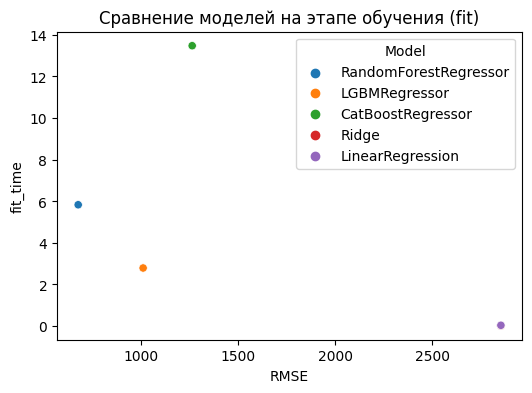

In [73]:
plt.figure(figsize = (6, 4))
sns.scatterplot(data = model_result , x ='RMSE', y='fit_time', hue="Model")
plt.title('Сравнение моделей на этапе обучения (fit)')
plt.show()

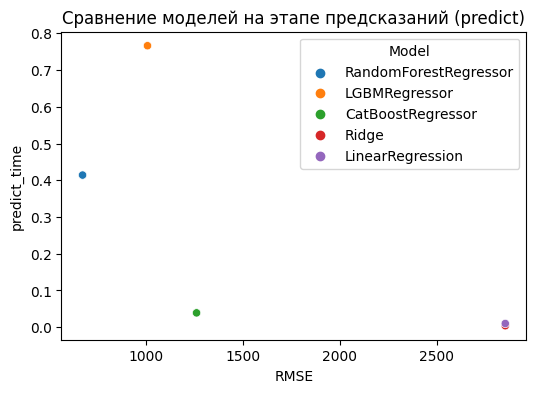

In [74]:
plt.figure(figsize = (6, 4))
sns.scatterplot(data = model_result, x ='RMSE', y='predict_time', hue="Model")
plt.title('Сравнение моделей на этапе предсказаний (predict)')
plt.show()

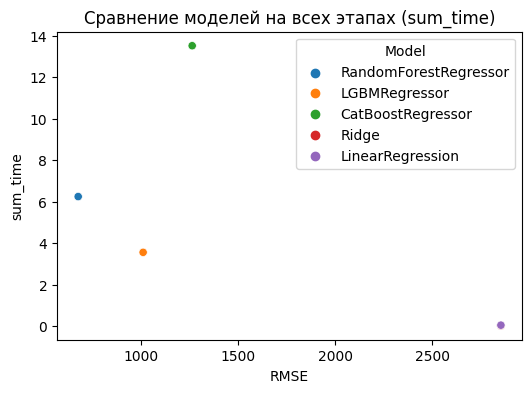

In [75]:
plt.figure(figsize = (6, 4))
sns.scatterplot(data = model_result, x ='RMSE', y='sum_time', hue="Model")
plt.title('Сравнение моделей на всех этапах (sum_time)')
plt.show()

<div style='border:solid blue 3px; padding: 20px'>
    
**Выводы:**

Наилучший результат показала себя модель случайного леса, однако на тесте результат Наилучшая модель - **LGBMRegressor** как по качеству RMSE = 1009, так и по суммарному времени работы в 3 сек. Наиболее близкий результат по качеству показала модель **CatBoostRegressor** с RMSE = 1597 - чуть лучше лидера, но по времени существенно отстает (12 сек). Неплохо себя показала модель **RandomForestRegressor** с RMSE = 1665, а по времени 8 сек. Наихудшие результаты у линейной регрессии

Посмотрим на результат моделей на тестовой выборке

In [76]:
RFR_fit_time, RFR = fit_time(RandomForestRegressor(n_estimators=10, random_state=RANDOM_STATE), X_train, y_train)
RFR_pred_time, RFR_predict = predict_time(RFR, X_test)
RFR_RMSE = np.sqrt(mean_squared_error(y_test, RFR_predict))
model_metrics(RFR_RMSE, RFR_fit_time, RFR_pred_time, 'RandomForestRegressor', model_result)

,RMSE,fit_time,predict_time,sum_time,Model
RandomForestRegressor,6452.55284,5.848319,0.421094,6.269413,RandomForestRegressor
LGBMRegressor,1009.458334,2.792967,0.766172,3.559139,LGBMRegressor
CatBoostRegressor,1262.201028,13.474651,0.039008,13.513659,CatBoostRegressor
Ridge,2852.60552,0.019005,0.004009,0.023014,Ridge
LinearRegression,2852.605558,0.041009,0.010009,0.051018,LinearRegression


In [77]:
LR_fit_time, LR_model = fit_time(LinearRegression(), X_train, y_train)
LR_pred_time, LR_predict = predict_time(LR_model, X_test)
LR_RMSE = np.sqrt(mean_squared_error(y_test, LR_predict))
model_metrics(LR_RMSE, LR_fit_time, LR_pred_time, 'LinearRegression', model_result)

,RMSE,fit_time,predict_time,sum_time,Model
RandomForestRegressor,6452.55284,5.848319,0.421094,6.269413,RandomForestRegressor
LGBMRegressor,1009.458334,2.792967,0.766172,3.559139,LGBMRegressor
CatBoostRegressor,1262.201028,13.474651,0.039008,13.513659,CatBoostRegressor
Ridge,2852.60552,0.019005,0.004009,0.023014,Ridge
LinearRegression,5900.908391,0.035007,0.004001,0.039008,LinearRegression


In [78]:
# Ridge_fit_time, Ridge = fit_time(Ridge(alpha=1, random_state=RANDOM_STATE), X_train, y_train)
# Ridge_pred_time, Ridge_predict = predict_time(Ridge, X_test)
# Ridge_RMSE = np.sqrt(mean_squared_error(y_test, Ridge_predict))
# model_metrics(Ridge_RMSE, Ridge_fit_time, Ridge_pred_time,'Ridge', model_result)

In [79]:
lgbm_fit_time, lgbm = fit_time(LGBMRegressor(
    n_estimators=1000, random_state=RANDOM_STATE, learning_rate=0.4, objective='rmse'), X_train, y_train)
lgbm_pred_time, lgbm_predict = predict_time(lgbm, X_test)
lgbm_RMSE = np.sqrt(mean_squared_error(y_test, lgbm_predict))
model_metrics(lgbm_RMSE, lgbm_fit_time, lgbm_pred_time, 'LGBMRegressor', model_result)

,RMSE,fit_time,predict_time,sum_time,Model
RandomForestRegressor,6452.55284,5.848319,0.421094,6.269413,RandomForestRegressor
LGBMRegressor,6434.953427,2.189489,0.600134,2.789623,LGBMRegressor
CatBoostRegressor,1262.201028,13.474651,0.039008,13.513659,CatBoostRegressor
Ridge,2852.60552,0.019005,0.004009,0.023014,Ridge
LinearRegression,5900.908391,0.035007,0.004001,0.039008,LinearRegression


In [80]:
catboost_fit_time, catboost = fit_time(CatBoostRegressor(
    loss_function='RMSE', learning_rate=0.4, verbose=100, n_estimators=1000, random_state=RANDOM_STATE), X_train, y_train)
catboost_pred_time, catboost_predict = predict_time(catboost, X_test)
catboost_RMSE = np.sqrt(mean_squared_error(y_test, catboost_predict))
model_metrics(catboost_RMSE, catboost_fit_time, catboost_pred_time, 'CatBoostRegressor', model_result)

0:	learn: 3427.7019892	total: 21.3ms	remaining: 21.3s
100:	learn: 1560.7117500	total: 1.24s	remaining: 11s
200:	learn: 1476.2764006	total: 2.43s	remaining: 9.66s
300:	learn: 1427.8856143	total: 3.62s	remaining: 8.4s
400:	learn: 1391.5748141	total: 4.83s	remaining: 7.22s
500:	learn: 1363.1172595	total: 6.07s	remaining: 6.05s
600:	learn: 1339.8684899	total: 7.27s	remaining: 4.83s
700:	learn: 1318.0069550	total: 8.51s	remaining: 3.63s
800:	learn: 1298.3634597	total: 9.7s	remaining: 2.41s
900:	learn: 1279.7703427	total: 10.9s	remaining: 1.19s
999:	learn: 1263.6452232	total: 12s	remaining: 0us


,RMSE,fit_time,predict_time,sum_time,Model
RandomForestRegressor,6452.55284,5.848319,0.421094,6.269413,RandomForestRegressor
LGBMRegressor,6434.953427,2.189489,0.600134,2.789623,LGBMRegressor
CatBoostRegressor,6398.430567,12.482184,0.033008,12.515192,CatBoostRegressor
Ridge,2852.60552,0.019005,0.004009,0.023014,Ridge
LinearRegression,5900.908391,0.035007,0.004001,0.039008,LinearRegression


In [81]:
model_result = model_result.sort_values(by='RMSE')
model_result

,RMSE,fit_time,predict_time,sum_time,Model
Ridge,2852.60552,0.019005,0.004009,0.023014,Ridge
LinearRegression,5900.908391,0.035007,0.004001,0.039008,LinearRegression
CatBoostRegressor,6398.430567,12.482184,0.033008,12.515192,CatBoostRegressor
LGBMRegressor,6434.953427,2.189489,0.600134,2.789623,LGBMRegressor
RandomForestRegressor,6452.55284,5.848319,0.421094,6.269413,RandomForestRegressor


<div class="alert alert-block alert-info">
<b>Комментарий студента</b>
    
Моя радость была недолгой после проверки моделей на тестовой выборке😱 Эт что, модели переобучились? Или почему так вышло?

<div class="alert alert-success">
    ✔️ <b>Комментарий ревьюера v2</b>

Такое ощущение, что у тебя была опечатка в функции predict_time и там просто всегда использовался X_valid (там опечатка просто valid и vaild), поэтому при тестировании лучшей модели возникла такая ситуация (сравнивались предсказания на валидациис с таргетом на тесте) 
    
Выглядит все равно, что модель немного переобучилась, но это не так критично.
</div>

<div style='border:solid violet 5px; padding: 20px'>

**ОБЩИЙ ВЫВОД:**

В данной работе выполнены ссновные шаги:
1) загружены данные;
2) данные изучены, сделана предобработка: обработаны пропуски и аномалии в столбцах;
3) неинформативные признаки были удалены;
4) подготовлены данные, созданы выборки для обучения моделей;
5) обучены четыре модели, одна из которых — LightGBM;
6) определено время обучения, время предсказания и качество моделей;
7) на основе полученных данных была выбрана лучшая модель - **CatBoost**. Модели были проверены на качество на тестовой выборке;
8) для оценки качества моделей была использована метрика RMSE;
9) значение наилучше метрики RMSE получилось 1597 у модели **CatBoostRegressor**, что меньше 2500 - по условию задачи;
10) суммарное время работы наилучшей модели составило 12 сек
    
**В ИТОГЕ:** по совокупности факторов качество+время работы лучшая модель **LGBMRegressor** на выборке с кодировкой категориальных признаков методом OrdinalEncoder